<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/20210211_LowRankSparseLungSoundSeparation_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    torch.cuda.empty_cache()

Tesla T4
0
0


/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [2]:
class UNet(torch.nn.Module):

    def __init__(self, kernel_size, in_channels, out_channels0, out_channels1, out_channels2, out_channels3):
        super().__init__()
 
        def Convs(in_ch, ks, out_ch):
            return torch.nn.Sequential(
                torch.nn.Conv1d(in_ch, out_ch, ks,padding=ks//2),
                torch.nn.BatchNorm1d(out_ch),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv1d(out_ch, out_ch, ks, padding=ks//2),
                torch.nn.BatchNorm1d(out_ch),
                torch.nn.ReLU(inplace=True)
            )   
 
        def upsample(in_ch, out_ch, scale_factor, mode):
            return torch.nn.Sequential(
                torch.nn.Upsample(scale_factor=scale_factor, mode=mode),
                torch.nn.Conv1d(in_ch, out_ch, 1, padding=0)
            )
 
        def ConvOut(in_ch,out_ch):
            return torch.nn.Sequential(
                torch.nn.Conv1d(in_ch, out_ch, 1, padding=0)
            )

        self.convs0enc = Convs(in_channels, kernel_size, out_channels0) # 1024
        self.convs1enc = Convs(out_channels0, kernel_size, out_channels1) # 512
        self.convs2enc = Convs(out_channels1, kernel_size, out_channels2) # 256
        self.convs3enc = Convs(out_channels2, kernel_size, out_channels3) # 128
        self.downsample = torch.nn.AvgPool1d(2)
        self.upsample32 = upsample(out_channels3, out_channels2, 2, 'linear') #torch.nn.Upsample(scale_factor=2,mode = 'bilinear')
        self.upsample21 = upsample(out_channels2, out_channels1, 2, 'linear') #torch.nn.Upsample(scale_factor=2,mode = 'bilinear')
        self.upsample10 = upsample(out_channels1, out_channels0, 2, 'linear') #torch.nn.Upsample(scale_factor=2,mode = 'bilinear')

        self.convs2dec = Convs(out_channels2 + out_channels2, kernel_size, out_channels2) # 256
        self.convs1dec = Convs(out_channels1 + out_channels1, kernel_size, out_channels1) # 512
        self.convs0dec = Convs(out_channels0 + out_channels0, kernel_size, out_channels0) # 1024
        self.conv_out = ConvOut(out_channels0, in_channels) # 1024

    def forward(self, x):
        #encoding
        convs0e = self.convs0enc(x) #x:(B,C,F)
        x = self.downsample(convs0e)
        convs1e = self.convs1enc(x)
        x = self.downsample(convs1e)
        convs2e = self.convs2enc(x)
        x = self.downsample(convs2e)
        convs3e = self.convs3enc(x)

        x = self.upsample32(convs3e)
        x = torch.cat((x, convs2e), 1)
        x = self.convs2dec(x)
        x = self.upsample21(x)
        x = torch.cat((x, convs1e), 1)
        x = self.convs1dec(x)
        x = self.upsample10(x)
        x = torch.cat((x, convs0e), 1)
        x = self.convs0dec(x)
        s = self.conv_out(x)

        return s

In [113]:
## L1 loss
class L1LossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        ctx.save_for_backward(input, lw)
        return torch.sum(torch.abs(input)*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw = ctx.saved_tensors
        grad_input = grad_output.clone()
        return (input - soft(input, lw)) * grad_input, torch.abs(input) * grad_input

class L1Loss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(L1Loss, self).__init__()
        self.fn = L1LossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


## Nuclear loss
class NuclearLossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        u, s, v = torch.svd(input)
        ctx.save_for_backward(input, lw, u, s, v)
        return torch.sum(s*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw, u, s, v = ctx.saved_tensors
        grad_input = grad_output.clone()
        svt_input = torch.matmul(torch.matmul(u, torch.diag_embed(soft(s,lw))), torch.transpose(v, -2, -1))
        return (input - svt_input) * grad_input, s * grad_input

class NuclearLoss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(NuclearLoss, self).__init__()
        self.fn = NuclearLossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


#anucloss = lambda x: torch.sum(torch.svd(x)[1])
anucloss = lambda z: torch.sum(torch.svd(z[:,0,:])[1]) + torch.sum(torch.svd(z[:,1,:])[1])
#anucloss = lambda z: torch.sum(torch.svd(z[:,0,:]**2+z[:,1,:]**2)[1])
al1loss = lambda x: torch.sum(torch.abs(x))
al2loss = lambda x: torch.sum(torch.abs(x)**2)

In [114]:
#signal_torch = torch.from_numpy(signal).float().to(device)
n_fft = 2048
stft_param = {'n_fft': n_fft, 'hop_length' : n_fft // 4, 'Fs': Fs}
Dstft = torch.stft(torch.from_numpy(signal).float(), 
               n_fft=stft_param['n_fft'], hop_length=stft_param['hop_length'], 
               return_complex=None, window=torch.hann_window(stft_param['n_fft']))
print(Dstft.shape)

ptstft_to_ptensor = lambda tx: tx[1:1025].permute(1,2,0)
ptfweight = lambda ptensor: torch.sqrt(torch.sum(torch.abs(ptensor), 0)) + 1e-12
ptequalize = lambda ptensor, ptfw: ptensor / ptfw
ptunequalize = lambda ptensor, ptfw: ptensor * ptfw

ptensor_to_ptstft = lambda tx, npd: np.concatenate((np.expand_dims(npd, axis=0), tx.permute(2,0,1).numpy()), 0)
ptstft_as_complex = lambda npx: npx[:,:,0] + 1j*npx[:,:,1]

# input data
#D = Dstft[1:1025,:,:].permute(1,2,0).to(device) #→(B:time,C:real&img,F:freq)
ptD = ptstft_to_ptensor(Dstft)
ptfwD = ptfweight(ptD)
D = ptequalize(ptD, ptfwD).to(device) #→(B:time,C:real&img,F:freq)

print(D.shape)
print(torch.min(D), torch.max(D))

#DD = ptensor_to_ptstft(D.detach().to('cpu'), Dstft[0,:,:])
#print(DD.shape)

torch.Size([1025, 257, 2])
torch.Size([257, 2, 1024])
tensor(-3.7599, device='cuda:0') tensor(3.4498, device='cuda:0')


In [115]:
import numpy as np
import os
import scipy.io.wavfile as swf

def read_file(filename):
    #read
    if os.path.exists(filename + '.wav') == False:
        Fs, data  = swf.read(filename + '.WAV')
    else:
        Fs, data = swf.read(filename + '.wav')
    
    #normalize between -1 and 1, change dtype double
    data = data.astype(np.float64)
    data = data / 32768.0
    print(data.shape)
    return Fs,data

from google.colab import drive
drive.mount('/content/drive')

filename = "/content/drive/MyDrive/share/data/LungSound/040221600_11k"

Fs, signal = read_file(filename)
nextpow2 = lambda n: int(np.ceil(np.log2(n)))
nt = min(2**17, 2**(nextpow2(len(signal))))
signal = signal[:nt]

print("Shape of waveform: {}".format(len(signal)))
print("Sample rate of waveform: {}".format(Fs))
print("range of samples: %f %f" % (np.min(signal), np.max(signal)))
t = np.arange(nt)/Fs

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(131072,)
Shape of waveform: 131072
Sample rate of waveform: 11025
range of samples: -0.341522 0.399994


-98.62546 39.472748


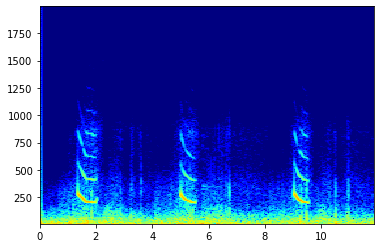

In [116]:
import matplotlib.pyplot as plt

def show_spectrogram(Dstft, stft_param, vrange=None, time=None, freq=None, dB=False):  # assumes Dstft to be a complex numpy array of shape (freq, time)
    t = np.arange(Dstft.shape[1]) * stft_param['hop_length'] / stft_param['Fs']
    f = np.linspace(0, stft_param['Fs'] / 2.0, Dstft.shape[0])

    if time is not None:
        tidx = (t>time[0])&(t<time[1])
    if freq is not None:
        fidx = (f>freq[0])&(f<freq[1])

    absD = np.abs(Dstft)
    if dB:
        absD = 20*np.log10(absD)
    if time is not None:
        absD = absD[:,tidx]
        t = t[tidx]
    if freq is not None:
        absD = absD[fidx,:]
        f = f[fidx]

    Dmin, Dmax = np.min(absD), np.max(absD)
    if vrange is not None:
        Dmin, Dmax = vrange

    plt.pcolormesh(t, f, absD, cmap='jet', vmin=Dmin, vmax=Dmax)
    print(np.min(absD), np.max(absD))


#DD = torch.view_as_complex(Dstft).numpy()
DD = ptstft_as_complex(ptensor_to_ptstft(ptD.detach().to('cpu'), Dstft[0,:,:]))
show_spectrogram(DD, stft_param, freq=[0,2000], dB=True, vrange=[-30,60])
#fig = plt.figure()
#plt.show()

In [122]:
#modelUnet = UNet(9, 2, 6, 12, 24, 48).to(device)
modelUnet = UNet(3, 2, 16, 32, 64, 128).to(device)
model = lambda x: modelUnet(x)
#model = lambda x: modelUnet(x.T.view(as_imgseq)).view(DDseq.shape[0],-1).T

ln = 1.
ls = 0.1 # ls = 1./np.sqrt(max(m,n)) / 16
alpha = 1.0 #0.5
#nucloss = NuclearLoss(lw=torch.tensor(alpha*ln))
#l1loss = L1Loss(lw=torch.tensor(alpha*ls))

In [133]:
lr = {'Adam': 1e-3, 'SGD': 3e-6}      #learning rate

optimizerM = torch.optim.Adam(modelUnet.parameters(), lr = lr['Adam'])
history_loss_Unet = []

num_iter = 1000
display_step = 20
for iter in range(num_iter):
    S = model(D)
    lnuc = ln*anucloss(D-S)
    ll1 = ls*al1loss(S)
    loss = alpha*(lnuc + ll1)
    #loss = alpha*ln*anucloss(D-S) + alpha*ls*al1loss(S)
    total_loss = 0.
    optimizerM.zero_grad()
    loss.backward(retain_graph=True)
    optimizerM.step()
    total_loss += loss.item() / alpha

    history_loss_Unet.append(total_loss)

    if (iter+1) % display_step == 0:
        print('[{:3d}/{}]: loss = {:.4f} = {:.4f} + {:.4f},  '.format(iter+1, num_iter, total_loss, lnuc.item(), ll1.item()))



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[ 20/300]: loss = 322.8410 = 225.4908 + 97.3502,  
[ 40/300]: loss = 303.3078 = 210.0980 + 93.2098,  
[ 60/300]: loss = 296.4864 = 209.2018 + 87.2846,  
[ 80/300]: loss = 316.2351 = 209.2083 + 107.0268,  
[100/300]: loss = 339.6515 = 208.9511 + 130.7005,  
[120/300]: loss = 333.2770 = 210.3660 + 122.9109,  
[140/300]: loss = 311.2693 = 206.9246 + 104.3448,  
[160/300]: loss = 326.1209 = 206.0660 + 120.0549,  
[180/300]: loss = 317.1976 = 207.1470 + 110.0505,  
[200/300]: loss = 295.8309 = 206.1303 + 89.7006,  
[220/300]: loss = 302.0333 = 207.7964 + 94.2368,  
[240/300]: loss = 299.2899 = 206.6024 + 92.6875,  
[260/300]: loss = 308.5905 = 207.8826 + 100.7079,  
[280/300]: loss = 307.2621 = 207.5113 + 99.7507,  
[300/300]: loss = 301.7638 = 206.6573 + 95.1065,  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


-116.78765716674295 36.6894324136956


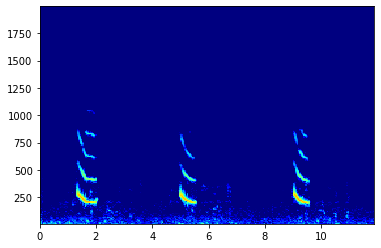

In [134]:
#ptS = S.detach().to('cpu')
ptS = ptunequalize(S.detach().to('cpu'), ptfwD)
SS = ptstft_as_complex(ptensor_to_ptstft(ptS, np.zeros((Dstft.shape[1],Dstft.shape[2]))))
show_spectrogram(SS, stft_param, freq=[0,2000], dB=True, vrange=[-30,60])


-98.0236 39.356667


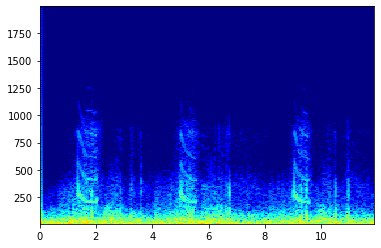

In [135]:
ptL = ptunequalize((D-S).detach().to('cpu'), ptfwD)
LL = ptstft_as_complex(ptensor_to_ptstft(ptL, Dstft[0,:,:]))
show_spectrogram(LL, stft_param, freq=[0,2000], dB=True, vrange=[-30,60])


In [ ]:

num_iter = 1000
display_step = num_iter // 50
optimizerM = torch.optim.SGD(modelUnet.parameters(), lr = lr['SGD'])
for iter in range(num_iter):

    total_loss = 0.
    with torch.no_grad():
        Sk = model(D).detach()
    Lk = (D-Sk).detach()
    S = model(D)
    loss = nucloss(Lk + alpha * (Sk - S))
    optimizerM.zero_grad()
    loss.backward(retain_graph=True)
    optimizerM.step()
    total_loss += loss.item() / alpha

    loss = l1loss(S + alpha * (Sk - S))           # good
    #loss = l1loss(S)                              # excellent if not noisy
    #optimizerM = torch.optim.SGD(model.parameters(), lr = 5e-1)
    optimizerM.zero_grad()
    loss.backward(retain_graph=True)
    optimizerM.step()
    total_loss += loss.item() / alpha

    #total_loss = (anucloss(Lk) + al1loss(S)) / alpha * lr  # compute loss precisely
    history_loss_Unet.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))


In [38]:
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import signal

from google.colab import drive
drive.mount('/content/drive')

filename = "/content/drive/MyDrive/share/data/LungSound/040221600_11k.wav"

waveform, Fs = torchaudio.load(filename)
ch, n_wav = waveform.shape
if ch > 1:
    waveform = torchaudio.transforms.Resample(Fs, Fs)(waveform[0, :].view(1,-1)) # extract a single wave channel
    print(waveform.shape)

nextpow2 = lambda n: int(np.ceil(np.log2(n)))

nt = min(2**17, 2**(nextpow2(len(waveform.T))))
#print(nt, 2**17, 2**(nextpow2(len(waveform.T))), waveform.shape)
waveform = waveform[:, :nt]

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(Fs))
print("range of samples: %f %f" % (torch.min(waveform), torch.max(waveform)))
t = np.arange(len(waveform.T))/Fs

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of waveform: torch.Size([1, 131072])
Sample rate of waveform: 11025
range of samples: -0.341522 0.399994


In [39]:
nfft = 2048
windowsize = nfft
offset = windowsize // 4
D = torchaudio.transforms.Spectrogram(nfft, windowsize, offset, power=None)(waveform)
shann = signal.hann(windowsize).sum()
D = D / shann
print("Shape of spectrogram: {}".format(D.size()))


1023.5
Shape of spectrogram: torch.Size([1, 1025, 257, 2])


/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


In [2]:


#transform spectrogram

y = D[0,:,:,:].permute(1,2,0)
print(y.shape)
z = y.permute(2,0,1)
z = torch.unsqueeze(z, 0)
print(z.shape)

X = torch.view_as_complex(D).clone().detach() #コピー
X = X[0,:,:].numpy()
time = np.arange(D.size(2))*offset/Fs
freq = np.linspace(0, Fs/2, D.size(1))

#Inverse conversion
#inv_waveform = torchaudio.transforms.GriffinLim(nfft, 128, windowsize, offset, power=1)(X)
inv_waveform = torch.istft(D, nfft, offset, windowsize)
print("Shape of waveform: {}".format(inv_waveform.size()))
print("Sample rate of waveform: {}".format(Fs))
t = np.arange(len(inv_waveform.T))/Fs
inv_waveform = inv_waveform * n * 2

#plot
fig = plt.figure(1)
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.xlim(0,len(waveform.T)/Fs)
plt.plot(t, waveform.t().numpy())
plt.show()
fig = plt.figure(2)
plt.pcolormesh(time, freq, np.abs(X), cmap='jet', vmin=0, vmax=0.001)
#plt.imshow(D.log2()[0,:,:].numpy(), origin='lower', cmap='jet')
#plt.imshow(np.abs(X), origin='lower', vmin=0, vmax=0.001, extent=[t.min(), t.max(), 0, Fs/2], aspect='auto', cmap='jet')
plt.xlabel("time [s]")
plt.ylabel("frequency [Hz]")
fig = plt.figure(3)
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.xlim(0,len(inv_waveform.T)/Fs)
plt.plot(t, inv_waveform.t().numpy())
plt.show()

print(waveform - inv_waveform)


OSError: ignored